*Disclaimer: This work is a giant pile of scratch work, and is not very organized.*

# Notes
- My models appear to be okay, but my preprocessing still possibly leaves something to be desired.
- With my method of preprocessing, I am able to get close to 0.80 accuracy with random forests, xgboost, and SVC. Part of the issue with SVC was alleviated by standardizing the data (as [Preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling) mentions).
   - The code uses almost all of the features to get this on xgboost, but for random forests and SVC they can be pared down to: all the Title columns, Sex, Age, Fare, SibSp, Parch, Cabin_N, Embarked_C (possibly even fewer)
- I tried preprocessing code from https://www.kaggle.com/sinakhorami/titanic-best-working-classifier, still on my own models, but was still only around 0.78 on Kaggle.

In [1]:
#!/usr/bin/env python

# (c) 2017, Chris Hodapp
# Code for: https://www.kaggle.com/c/titanic

# "It is your job to predict if a passenger survived the sinking of
# the Titanic or not. For each PassengerId in the test set, you must
# predict a 0 or 1 value for the Survived variable."  "Your score is
# the percentage of passengers you correctly predict."

import pandas
import matplotlib
import matplotlib.pyplot as plt
import numpy
import xgboost
import sklearn
import sklearn.model_selection
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.ensemble
import sklearn.svm

/nix/store/11gkg09dzkvamnfiygipz78m2gjvxrz6-python3-3.5.4-env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Another person's preprocessing code, for comparison
import sinakhorami_preprocess

/home/hodapp/source/kaggle-titanic/sinakhorami_preprocess.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list


## Loading & Transformation:

In [3]:
pandas.set_option("display.width", None)

# Load data:
train_raw = pandas.read_csv("train.csv")
test_raw = pandas.read_csv("test.csv")

In [4]:
# Some titles are equivalent:
equiv = {
    "Jonkheer": "Master",
    "Mlle": "Miss",
    "Ms": "Miss",
    "Mme": "Mrs",
    "Capt": "Sir",
    "Don": "Sir",
    "Major": "Sir",
    "Col": "Sir",
    "Dona": "Lady",
    "Countess": "Lady",
}
def getprefix(name):
    prefix = [pt[:-1] for pt in name.split(" ") if pt.endswith(".")][0]
    return equiv.get(prefix, prefix)

def cabin_num(s):
    parts = s.split(" ")
    if parts[0] and len(parts[0]) > 1:
        return int(parts[0][1:])
    else:
        return 0

def xform_input(df):
    # One-hot encode categorical Embarked column
    # Turn column "Sex" to a number - 0 for male, 1 for female
    # (it has only these two categories, all non-null)
    # Extract number from Cabin (pick first if many)
    # Extract first letter of Cabin and one-hot encode
    # Extract title (Mr, Mrs, Mme, Captain, etc.) from Title, one-hot encode
    onehot_emb = pandas.get_dummies(df.Embarked, "Embarked")
    onehot_cabin = pandas.get_dummies([i[0] for i in df.Cabin.fillna("N")], "Cabin")
    onehot_title = pandas.get_dummies([getprefix(n) for n in df.Name if "." in n], "Title")
    counts = train_raw.groupby("Ticket", as_index=False).size().reset_index(name="Count")
    df2 = train_raw.merge(counts, on="Ticket")
    return df.assign(Sex = numpy.where(df.Sex == "male", 0, 1)) \
             .assign(FarePer = df2.Fare / df2.Count) \
             .assign(Alone = ((df2.SibSp + df2.Parch) == 0)) \
             .assign(CabinNum = df.Cabin.fillna("").apply(cabin_num)) \
             .drop("Embarked", axis=1) \
             .drop("Cabin", axis=1) \
             .join(onehot_cabin) \
             .join(onehot_emb) \
             .join(onehot_title)

## Raw data:

In [5]:
train_raw.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature selection:

In [6]:
# Do some initial transformation:
train = xform_input(train_raw)

# Select columns ('prefix_cols' grabs entire group by prefix):
prefix_cols = ["Title", "Embarked", "Cabin"]
def matches_prefix(col):
    for p in prefix_cols:
        if col.startswith(p + "_"): return True
    return False
cols = ["Sex", "Age", "Fare", "SibSp", "Parch", "Pclass", "CabinNum"] + \
    [i for i in train.columns if matches_prefix(i + "_")]
# ["FarePer", "Count", "Pclass"] \
train_X = train.loc[:, cols].copy()
train_Y = train.loc[:, "Survived"].copy()

test = xform_input(test_raw)
test.loc[:,"Cabin_T"] = 0
test_X = test.loc[:, cols].copy()

## Missing data:

In [7]:
# Fare has just one missing value to take care of
# (for which we just fill in the average):
fare_avg = (train_X.Fare.sum() + test_X.Fare.sum()) / (train_X.Fare.count() + test_X.Fare.count())
# fillna(..., inplace=True) isn't working:
test_X.loc[:,"Fare"] = test_X.Fare.fillna(fare_avg)

# Age has a lot more; split apart the missing Age rows
# from both training & test:
mask_train = train_X.Age.isnull()
mask_test = test_X.Age.isnull()
age_valid = pandas.concat([train_X[~mask_train],  test_X[~mask_test]])
age_valid_Y = age_valid.Age
age_valid_X = age_valid.drop("Age", axis=1)
train_age_null = train_X[mask_train].drop("Age", axis=1)
test_age_null = test_X[mask_test].drop("Age", axis=1)

In [8]:
age_valid.shape[0], train_age_null.shape[0], test_age_null.shape[0]

(1046, 177, 86)

In [9]:
train_age_null.head(5)

,Sex,Fare,SibSp,Parch,Pclass,CabinNum,Cabin_A,Cabin_B,Cabin_C,Cabin_D,...,Embarked_Q,Embarked_S,Title_Dr,Title_Lady,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Title_Sir
5,0,8.4583,0,0,3,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
17,0,13.0000,0,0,2,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
19,1,7.2250,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
26,0,7.2250,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
28,1,7.8792,0,0,3,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [10]:
test_X.isnull().sum()

Sex              0
Age             86
Fare             0
SibSp            0
Parch            0
Pclass           0
CabinNum         0
Cabin_A          0
Cabin_B          0
Cabin_C          0
Cabin_D          0
Cabin_E          0
Cabin_F          0
Cabin_G          0
Cabin_N          0
Cabin_T          0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
Title_Dr         0
Title_Lady       0
Title_Master     0
Title_Miss       0
Title_Mr         0
Title_Mrs        0
Title_Rev        0
Title_Sir        0
dtype: int64

In [11]:
age_valid_X.isnull().sum()

Sex             0
Fare            0
SibSp           0
Parch           0
Pclass          0
CabinNum        0
Cabin_A         0
Cabin_B         0
Cabin_C         0
Cabin_D         0
Cabin_E         0
Cabin_F         0
Cabin_G         0
Cabin_N         0
Cabin_T         0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
Title_Dr        0
Title_Lady      0
Title_Master    0
Title_Miss      0
Title_Mr        0
Title_Mrs       0
Title_Rev       0
Title_Sir       0
dtype: int64

In [12]:
# Replace missing values of Age based on other values.
# Since this is an unrelated model (not the one we are predicting
# Survived from), we aren't tainting it by including test data in it.
rfr = sklearn.ensemble.RandomForestRegressor(n_estimators=2000, n_jobs=-1)
rfr = rfr.fit(age_valid_X, age_valid_Y)

In [13]:
train_X.loc[mask_train, "Age"] = rfr.predict(train_age_null)
test_X.loc[mask_test, "Age"]   = rfr.predict(test_age_null)

## Standardize data:

In [14]:
ss = sklearn.preprocessing.StandardScaler().fit(train_X)
train_X.iloc[:,:] = ss.transform(train_X)
test_X.iloc[:,:] = ss.transform(test_X)

## Transformed data:

In [15]:
train_X.head(5)

,Sex,Age,Fare,SibSp,Parch,Pclass,CabinNum,Cabin_A,Cabin_B,Cabin_C,...,Embarked_Q,Embarked_S,Title_Dr,Title_Lady,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Title_Sir
0,-0.737695,-0.560480,-0.502445,0.432793,-0.473674,0.827377,-0.413974,-0.130856,-0.235981,-0.266296,...,-0.307562,0.619306,-0.088986,-0.047431,-0.219625,-0.511898,0.850532,-0.405840,-0.082339,-0.088986
1,1.355574,0.609172,0.786845,0.432793,-0.473674,-1.566107,2.778724,-0.130856,-0.235981,3.755222,...,-0.307562,-1.614710,-0.088986,-0.047431,-0.219625,-0.511898,-1.175735,2.464027,-0.082339,-0.088986
2,1.355574,-0.268067,-0.488854,-0.474545,-0.473674,0.827377,-0.413974,-0.130856,-0.235981,-0.266296,...,-0.307562,0.619306,-0.088986,-0.047431,-0.219625,1.953514,-1.175735,-0.405840,-0.082339,-0.088986
3,1.355574,0.389862,0.420730,0.432793,-0.473674,-1.566107,4.206048,-0.130856,-0.235981,3.755222,...,-0.307562,0.619306,-0.088986,-0.047431,-0.219625,-0.511898,-1.175735,2.464027,-0.082339,-0.088986
4,-0.737695,0.389862,-0.486337,-0.474545,-0.473674,0.827377,-0.413974,-0.130856,-0.235981,-0.266296,...,-0.307562,0.619306,-0.088986,-0.047431,-0.219625,-0.511898,0.850532,-0.405840,-0.082339,-0.088986


## Models to test

In [16]:
# Make a zoo of models to test:
logistic = sklearn.linear_model.LogisticRegression(C = 1e5)
rf = sklearn.ensemble.RandomForestClassifier(
    n_estimators=100, criterion="entropy", max_depth=5, n_jobs=-1,
    random_state=12348)
rf2 = sklearn.ensemble.RandomForestClassifier(
    n_estimators=200, criterion="entropy", max_depth=5, n_jobs=-1,
    random_state=12348)
rf3 = sklearn.ensemble.RandomForestClassifier(
    n_estimators=100, criterion="entropy", max_depth=10, n_jobs=-1,
    random_state=12348)
rf4 = sklearn.ensemble.RandomForestClassifier(
    n_estimators=200, criterion="entropy", max_depth=10, n_jobs=-1,
    random_state=12348)
ab = sklearn.ensemble.AdaBoostClassifier(
    n_estimators=400,
    learning_rate=1.0,
    random_state=12345)
svc = sklearn.svm.SVC()
xgb = xgboost.sklearn.XGBClassifier(nthread=-1, seed=12345)

models = {
    "Logistic regression": logistic,
    "Random forest(100,5)": rf,
    "Random forest(200,5)": rf2,
    "Random forest(100,10)": rf3,
    "Random forest(200,10)": rf4,
    "AdaBoost": ab,
    "SVC": svc,
    "XGBoost": xgb
}

### My preprocessing & models:

In [17]:
data = []
for name in models:
    scores = sklearn.model_selection.cross_val_score(
        models[name],
        train_X,
        train_Y,
        cv=sklearn.model_selection.StratifiedShuffleSplit())
    data.append((name, scores.mean(), scores.std() * 2))
data = pandas.DataFrame.from_records(
    data, columns=("Model", "Mean Accuracy", "Std. Dev."))
data.sort_values("Model", inplace=True)

In [18]:
data

,Model,Mean Accuracy,Std. Dev.
5,AdaBoost,0.810000,0.091867
6,Logistic regression,0.828889,0.049889
2,"Random forest(100,10)",0.835556,0.067257
1,"Random forest(100,5)",0.833333,0.079505
0,"Random forest(200,10)",0.863333,0.062893
3,"Random forest(200,5)",0.852222,0.060492
7,SVC,0.823333,0.098106
4,XGBoost,0.825556,0.061303


### My models, but sinakhorami's features:

In [19]:
data = []
for name in models:
    scores = sklearn.model_selection.cross_val_score(
        models[name],
        sinakhorami_preprocess.train[:,1::],
        sinakhorami_preprocess.train[:,0],
        cv=sklearn.model_selection.StratifiedShuffleSplit())
    data.append((name, scores.mean(), scores.std() * 2))
data = pandas.DataFrame.from_records(
    data, columns=("Model", "Mean Accuracy", "Std. Dev."))
data.sort_values("Model", inplace=True)

In [20]:
data

,Model,Mean Accuracy,Std. Dev.
5,AdaBoost,0.768889,0.090976
6,Logistic regression,0.818889,0.056262
2,"Random forest(100,10)",0.804444,0.046825
1,"Random forest(100,5)",0.831111,0.075556
0,"Random forest(200,10)",0.810000,0.065508
3,"Random forest(200,5)",0.810000,0.025240
7,SVC,0.811111,0.062854
4,XGBoost,0.820000,0.071527


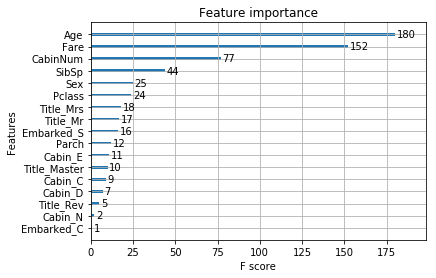

In [21]:
%matplotlib inline
matplotlib.pyplot.figure()
xgb.fit(train_X, train_Y)
xgboost.plot_importance(xgb, ax=matplotlib.pyplot.gca())

In [22]:
def plot_validation(train_scores, test_scores, param_range, linear=False):
    # Code adapted from:
    # http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
    train_scores_mean = numpy.mean(train_scores, axis=1)
    train_scores_std = numpy.std(train_scores, axis=1)
    test_scores_mean = numpy.mean(test_scores, axis=1)
    test_scores_std = numpy.std(test_scores, axis=1)
    plt.ylabel("Score")
    #plt.ylim(0.0, 1.1)
    lw = 2
    if linear:
        plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    else:
        plt.semilogx(param_range, train_scores_mean, label="Training score",
                     color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    if linear:
        plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    else:
        plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                     color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

## Random Forest experimentation

In [23]:
rf = sklearn.ensemble.RandomForestClassifier(
    n_estimators=100, criterion="entropy", max_depth=4, n_jobs=-1,
    random_state=12348)
rf = rf.fit(train_X, train_Y)
features = pandas.DataFrame(
    {"Feature": list(train_X.columns),
     "Importance": rf.feature_importances_})
features.sort_values("Importance", inplace=True, ascending=False)
features

,Feature,Importance
0,Sex,0.234737
23,Title_Mr,0.233357
5,Pclass,0.086618
2,Fare,0.076573
22,Title_Miss,0.061080
14,Cabin_N,0.051759
6,CabinNum,0.051462
24,Title_Mrs,0.048054
1,Age,0.046372
3,SibSp,0.036827


In [24]:
def test_estimators(est_range, max_depth):
    train_scores, valid_scores = sklearn.model_selection.validation_curve(
        sklearn.ensemble.RandomForestClassifier(
            criterion="entropy", max_depth=max_depth, n_jobs=-1,
            random_state=12348),
        train_X, train_Y,
        "n_estimators", est_range, cv=sklearn.model_selection.StratifiedShuffleSplit())
    plt.title("Random Forest Classifier, max_depth={0}".format(max_depth))
    plt.xlabel("n_estimators")
    plot_validation(train_scores, valid_scores, est_range)

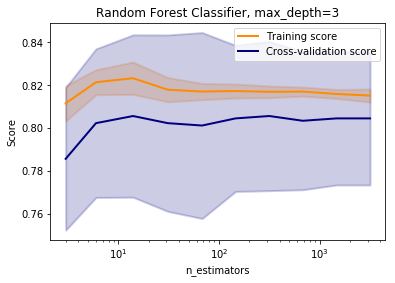

In [25]:
test_estimators(numpy.logspace(0.5, 3.5, 10).astype(numpy.int64), 3)

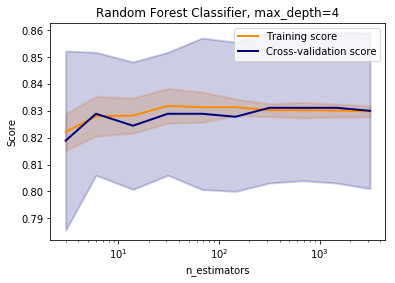

In [26]:
test_estimators(numpy.logspace(0.5, 3.5, 10).astype(numpy.int64), 4)

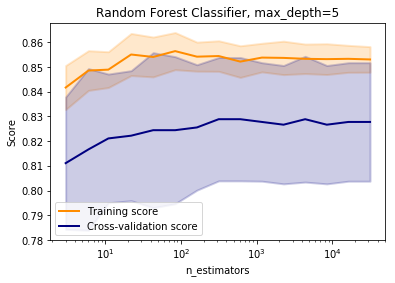

In [27]:
test_estimators(numpy.logspace(0.5, 4.5, 15).astype(numpy.int64), 5)

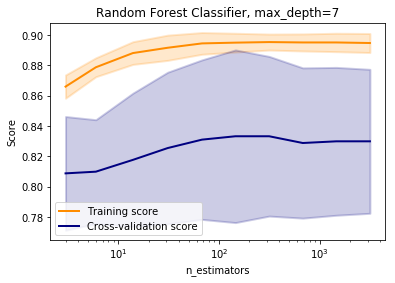

In [28]:
test_estimators(numpy.logspace(0.5, 3.5, 10).astype(numpy.int64), 7)

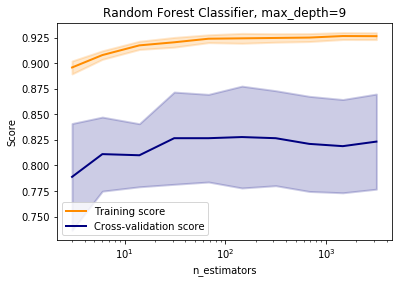

In [29]:
test_estimators(numpy.logspace(0.5, 3.5, 10).astype(numpy.int64), 9)

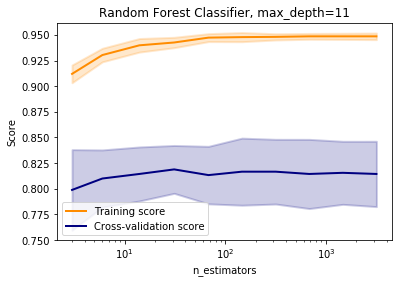

In [30]:
test_estimators(numpy.logspace(0.5, 3.5, 10).astype(numpy.int64), 11)

In [31]:
def test_depth(depth_range, n_estimators):
    train_scores, valid_scores = sklearn.model_selection.validation_curve(
        sklearn.ensemble.RandomForestClassifier(
            criterion="entropy", n_estimators=n_estimators, n_jobs=-1,
            random_state=12348),
        train_X, train_Y,
        "max_depth", depth_range, cv=sklearn.model_selection.StratifiedShuffleSplit())
    plt.title("Random Forest Classifier, n_estimators={0}".format(n_estimators))
    plt.xlabel("max_depth")
    plot_validation(train_scores, valid_scores, depth_range, linear=True)

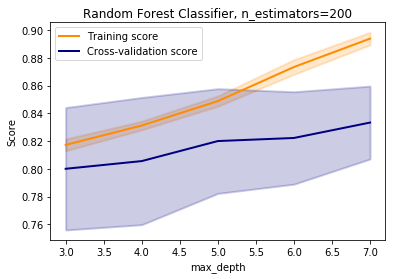

In [32]:
test_depth(numpy.arange(3, 8).astype(numpy.int64), 200)

## SVM validation curves

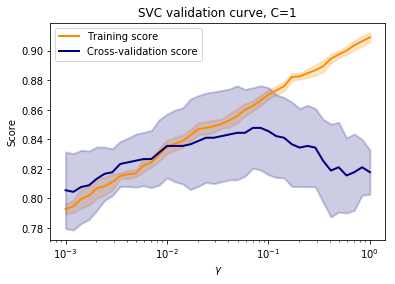

In [33]:
rng = numpy.logspace(-3, 0, 40)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    sklearn.svm.SVC(C=1, probability=True), train_X, train_Y,
    "gamma", rng, cv=sklearn.model_selection.StratifiedShuffleSplit())
plt.title("SVC validation curve, C=1")
plt.xlabel("$\gamma$")
plot_validation(train_scores, valid_scores, rng)

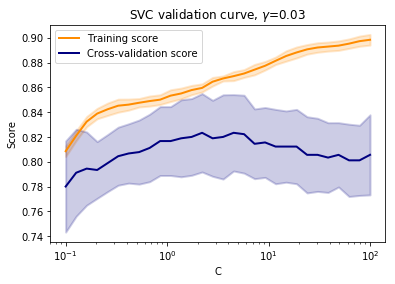

In [34]:
rng = numpy.logspace(-1, 2, 30)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    sklearn.svm.SVC(gamma=0.03, probability=True), train_X, train_Y,
    "C", rng, cv=sklearn.model_selection.StratifiedShuffleSplit())
plt.title("SVC validation curve, $\gamma$=0.03")
plt.xlabel("C")
plot_validation(train_scores, valid_scores, rng)

## xgboost experimentation

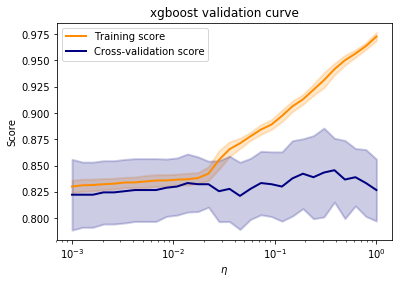

In [35]:
xgb = xgboost.sklearn.XGBClassifier(nthread=-1, seed=12345)
rng = numpy.logspace(-3, 0, 30)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    xgb, train_X, train_Y,
    "learning_rate", rng, cv=sklearn.model_selection.StratifiedShuffleSplit())
plt.title("xgboost validation curve")
plt.xlabel("$\eta$")
plot_validation(train_scores, valid_scores, rng)

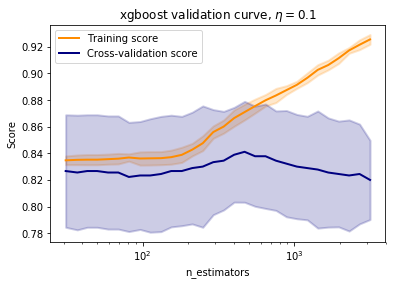

In [36]:
xgb = xgboost.sklearn.XGBClassifier(nthread=-1, seed=12345, learning_rate=0.01)
rng = numpy.logspace(1.5, 3.5, 30).astype(numpy.int64)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    xgb, train_X, train_Y,
    "n_estimators", rng, cv=sklearn.model_selection.StratifiedShuffleSplit())
plt.title("xgboost validation curve, $\eta=0.1$")
plt.xlabel("n_estimators")
plot_validation(train_scores, valid_scores, rng)

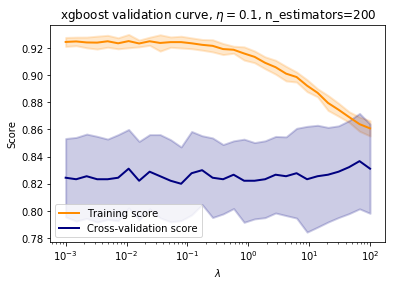

In [37]:
xgb = xgboost.sklearn.XGBClassifier(nthread=-1, seed=12345, learning_rate=0.1, n_estimators=200)
rng = numpy.logspace(-3, 2, 30)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    xgb, train_X, train_Y,
    "reg_lambda", rng, cv=sklearn.model_selection.StratifiedShuffleSplit())
plt.title("xgboost validation curve, $\eta=0.1$, n_estimators=200")
plt.xlabel("$\lambda$")
plot_validation(train_scores, valid_scores, rng)

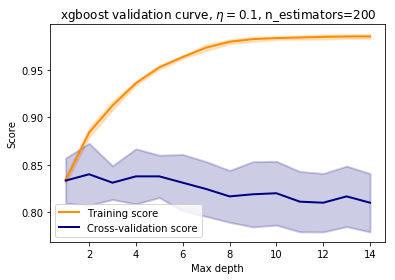

In [38]:
xgb = xgboost.sklearn.XGBClassifier(nthread=-1, seed=12345, learning_rate=0.1, n_estimators=200)
rng = numpy.arange(1, 15)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    xgb, train_X, train_Y,
    "max_depth", rng, cv=sklearn.model_selection.StratifiedShuffleSplit())
plt.title("xgboost validation curve, $\eta=0.1$, n_estimators=200")
plt.xlabel("Max depth")
plot_validation(train_scores, valid_scores, rng, linear=True)

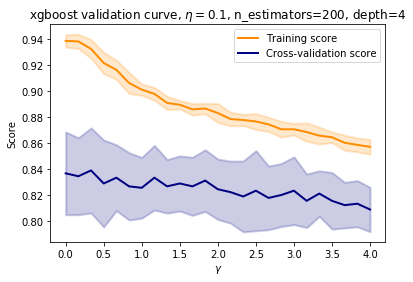

In [39]:
xgb = xgboost.sklearn.XGBClassifier(nthread=-1, seed=12345, learning_rate=0.1, n_estimators=200, max_depth=4)
rng = numpy.linspace(0, 4, 25)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    xgb, train_X, train_Y,
    "gamma", rng, cv=sklearn.model_selection.StratifiedShuffleSplit())
plt.title("xgboost validation curve, $\eta=0.1$, n_estimators=200, depth=4")
plt.xlabel("$\gamma$")
plot_validation(train_scores, valid_scores, rng, linear=True)

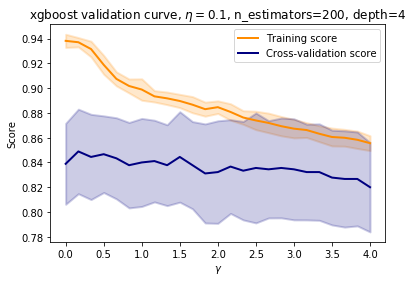

In [40]:
xgb = xgboost.sklearn.XGBClassifier(nthread=-1, seed=12345, learning_rate=0.1, n_estimators=200, max_depth=4)
rng = numpy.linspace(0, 4, 25)
train_scores, valid_scores = sklearn.model_selection.validation_curve(
    xgb, train_X, train_Y,
    "gamma", rng, cv=sklearn.model_selection.StratifiedShuffleSplit())
plt.title("xgboost validation curve, $\eta=0.1$, n_estimators=200, depth=4")
plt.xlabel("$\gamma$")
plot_validation(train_scores, valid_scores, rng, linear=True)

## Submission code

In [41]:
# Generate submission:
#model = sklearn.ensemble.RandomForestClassifier(
#        n_estimators=100, criterion="entropy", max_depth=5, n_jobs=-1)
model = xgboost.sklearn.XGBClassifier(nthread=-1, learning_rate=0.01, n_estimators=200, max_depth=4)
#model = sklearn.svm.SVC(gamma=0.1, probability=True)
#model = sklearn.svm.SVC()
#model.fit(sinakhorami_preprocess.train[:,1::],
#          sinakhorami_preprocess.train[:,0],
#         )
model.fit(train_X, train_Y)
submission = test[["PassengerId"]]
#submission = submission.assign(Survived = model.predict(sinakhorami_preprocess.test))
submission = submission.assign(Survived = model.predict(test_X))
submission.to_csv("submission.csv", index=False)